In [79]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import sys
module_path = os.path.abspath(os.path.join('..', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [80]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from gmvae import GMVAE
from circular_vae import CircularVAE
from base_vae import BaseVAE
from utils import *
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

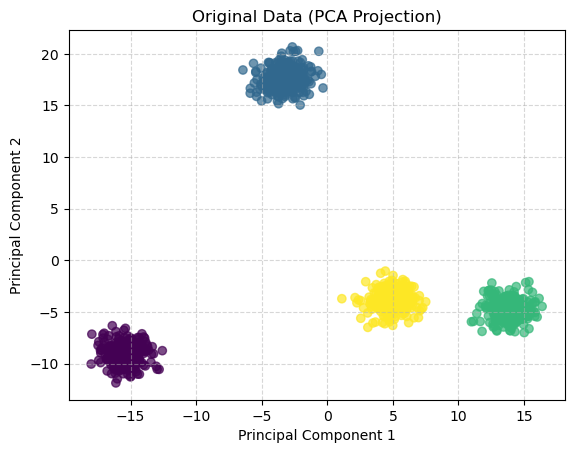

In [99]:
# --- 1. Generate Synthetic Data ---
n_samples = 1000
n_features = 50
centers = 4

X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=centers, random_state=42)
X = np.abs(X).astype(np.int32).astype(np.float32) # Make counts positive 
row_sums = X.sum(axis=1)
keep_indices = row_sums > 0
X = X[keep_indices]
y = y[keep_indices]
# X = StandardScaler().fit_transform(X) # Scale for stability
X_tensor = torch.tensor(X, dtype=torch.float32)
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_tensor) # Use the numpy array X before it becomes a tensor
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.title("Original Data (PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

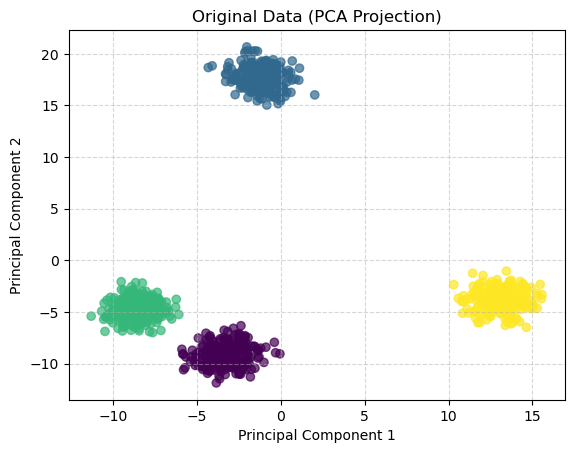

In [100]:
plt.scatter(X_pca[:, 2], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.title("Original Data (PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [95]:
# --- 2. Initialize Model ---
n_latent = 1
# Use blob centers as the fixed means for the prior
fixed_means = torch.tensor([-2,-1, 0 , 1], dtype=torch.float32)
print("fixed means", fixed_means)
model = GMVAE(
    n_input=n_features,
    n_latent=n_latent,
    fixed_means=fixed_means
)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
print(f"Data shape after filtering: {X_tensor.shape}")
print(f"Minimum value in data: {X_tensor.min().item()}")

fixed means tensor([-2., -1.,  0.,  1.])
Data shape after filtering: torch.Size([1000, 50])
Minimum value in data: 0.0


In [96]:
# KL Annealing parameters
n_epochs = 200
n_warmup_epochs = 50 # The first 50 epochs will be the "grace period"
kl_weight = 0.0

# Lists for plotting loss later
loss_history = []
kl_weight_history = []


for epoch in range(n_epochs):
    model.train()
    
    # --- Calculate the KL weight for this epoch ---
    # Linearly increase weight from 0 to 1 over the warmup period
    if epoch < n_warmup_epochs:
        kl_weight = epoch / n_warmup_epochs
    else:
        kl_weight = 1.0
    
    kl_weight_history.append(kl_weight)
    # ---------------------------------------------

    optimizer.zero_grad()
    
    forward_output = model(X_tensor)
    # --- Pass the kl_weight to the loss function ---
    loss_dict = model.loss(X_tensor, forward_output, kl_weight=kl_weight)
    
    loss = loss_dict["loss"]
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Keep gradient clipping
    optimizer.step()
    
    loss_history.append(loss.item())

    if (epoch + 1) % 20 == 0:
        print(
            f"Epoch [{epoch+1}/{n_epochs}], "
            f"Loss: {loss.item():.4f}, "
            f"KL Weight: {kl_weight:.2f}, "
            f"Recon Loss: {loss_dict['recon_loss']:.4f}, "
            f"KL Local: {loss_dict['kl_local']:.4f}"
        )

Epoch [20/200], Loss: 133.6352, KL Weight: 0.38, Recon Loss: 131.3138, KL Local: 6.1091
Epoch [40/200], Loss: 134.6328, KL Weight: 0.78, Recon Loss: 129.7845, KL Local: 6.2158
Epoch [60/200], Loss: 134.7410, KL Weight: 1.00, Recon Loss: 128.4956, KL Local: 6.2454
Epoch [80/200], Loss: 133.3988, KL Weight: 1.00, Recon Loss: 126.7068, KL Local: 6.6920
Epoch [100/200], Loss: 131.9962, KL Weight: 1.00, Recon Loss: 124.9511, KL Local: 7.0452
Epoch [120/200], Loss: 130.4389, KL Weight: 1.00, Recon Loss: 123.2430, KL Local: 7.1959
Epoch [140/200], Loss: 127.8676, KL Weight: 1.00, Recon Loss: 120.2414, KL Local: 7.6262
Epoch [160/200], Loss: 124.1110, KL Weight: 1.00, Recon Loss: 116.0838, KL Local: 8.0272
Epoch [180/200], Loss: 120.3650, KL Weight: 1.00, Recon Loss: 112.2554, KL Local: 8.1096
Epoch [200/200], Loss: 116.6489, KL Weight: 1.00, Recon Loss: 108.2982, KL Local: 8.3506


Statistics for each cluster:
Cluster 0: mean=-1.780, std=0.176, min=-2.295, max=-1.270
Cluster 1: mean=-0.509, std=0.146, min=-0.880, max=-0.102
Cluster 2: mean=0.863, std=0.187, min=0.399, max=1.324
Cluster 3: mean=-0.402, std=0.217, min=-0.968, max=0.214


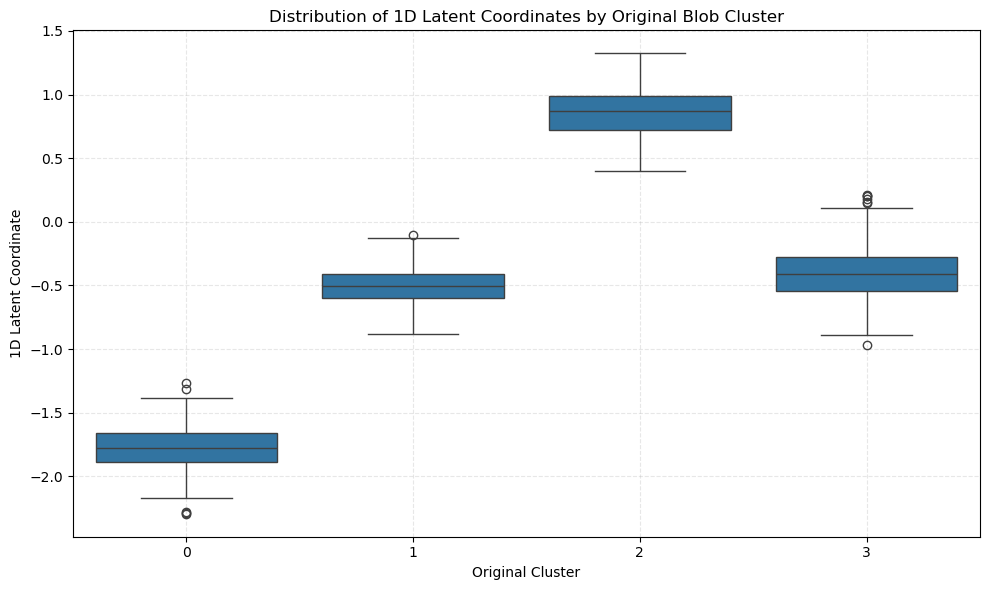

In [98]:
# --- 3. Extract Latent Representations and Create Multi-Box Plot ---
model.eval()
with torch.no_grad():
    # Get the latent representations
    forward_output = model(X_tensor)
    z = forward_output['z']  # This should be the 1D latent representation
    
# Convert to numpy for plotting
z_np = z.numpy().flatten()

# Create a DataFrame for easier plotting
import pandas as pd
import seaborn as sns

# Create DataFrame with latent coordinates and original cluster labels
df = pd.DataFrame({
    'latent_coord': z_np,
    'original_cluster': y
})

# Create the multi-box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='original_cluster', y='latent_coord')
plt.title('Distribution of 1D Latent Coordinates by Original Blob Cluster')
plt.xlabel('Original Cluster')
plt.ylabel('1D Latent Coordinate')
plt.grid(True, linestyle='--', alpha=0.3)

# Add some statistics
print("Statistics for each cluster:")
for cluster in sorted(df['original_cluster'].unique()):
    cluster_data = df[df['original_cluster'] == cluster]['latent_coord']
    print(f"Cluster {cluster}: mean={cluster_data.mean():.3f}, std={cluster_data.std():.3f}, "
          f"min={cluster_data.min():.3f}, max={cluster_data.max():.3f}")

plt.tight_layout()
plt.show()


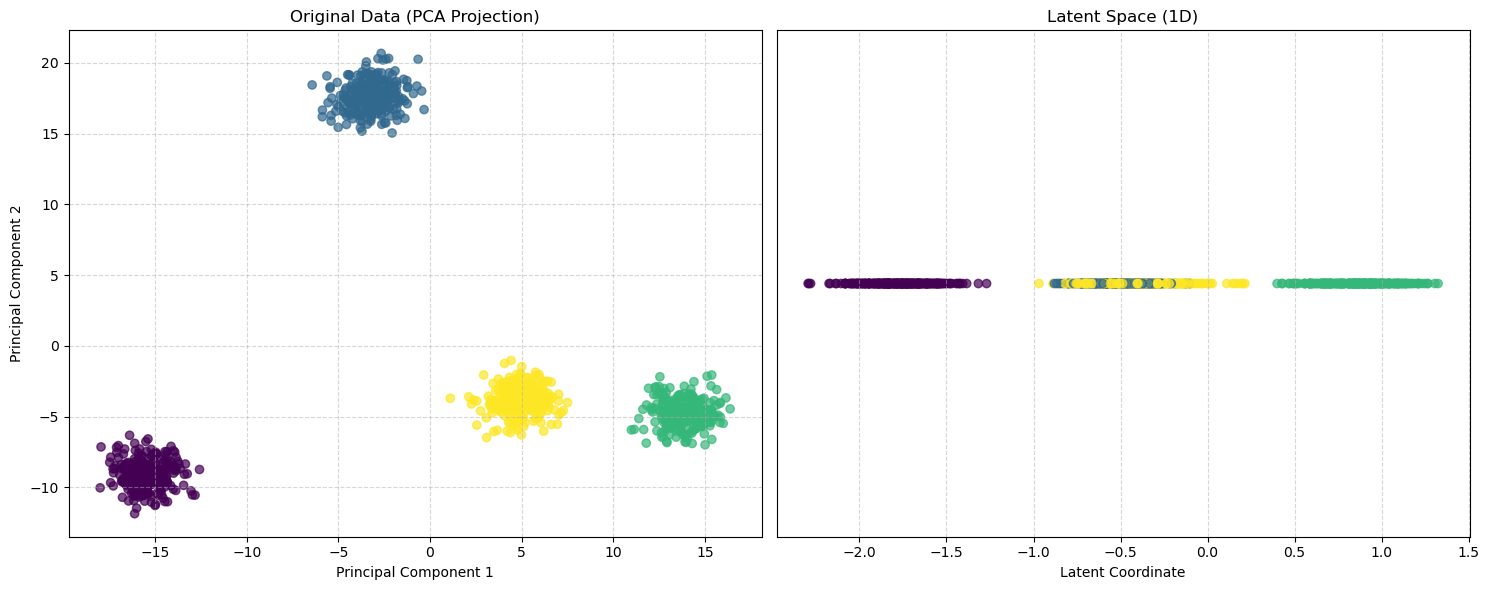


Fixed means used in the model: [-2. -1.  0.  1.]
Number of samples per cluster:
Cluster 0: 250 samples
Cluster 1: 250 samples
Cluster 2: 250 samples
Cluster 3: 250 samples


In [101]:
# --- 4. Additional Visualizations ---
# Create a side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Original PCA visualization
ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
ax1.set_title("Original Data (PCA Projection)")
ax1.set_xlabel("Principal Component 1")
ax1.set_ylabel("Principal Component 2")
ax1.grid(True, linestyle='--', alpha=0.5)

# Latent space visualization (1D projected onto 2D for visualization)
# Create a 2D scatter plot where x=latent_coord and y=0 (or some other constant)
ax2.scatter(z_np, np.zeros_like(z_np), c=y, cmap='viridis', alpha=0.7)
ax2.set_title("Latent Space (1D)")
ax2.set_xlabel("Latent Coordinate")
ax2.set_ylabel("")
ax2.set_yticks([])  # Remove y-axis ticks since it's 1D
ax2.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Show the relationship between original clusters and latent coordinates
print(f"\nFixed means used in the model: {fixed_means.numpy()}")
print(f"Number of samples per cluster:")
for cluster in sorted(np.unique(y)):
    count = np.sum(y == cluster)
    print(f"Cluster {cluster}: {count} samples")
